In [53]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [78]:
# This is the data structure to store the huge expressions we want to deal with
# Children would give us the information about the children of current expression, op tells what expression was used on these children
# We would also need the derivative of the root wrt the leaf nodes which in some case would be weights in a neural network.(This is important during the back-propogation.
class Value:
    def __init__(self,data,_children=(), _op='',label=""):
        self.data = data;
        self.prev = set(_children);
        self.op = _op;
        self.label = label;
        self._backward = lambda : None
        self.grad = 0.0; # At initialization, we are assuming that every value does not effect the final output(loss function)
        
    def __repr__(self):
        return f"Value(data={self.data})"

    # If you do a*2, python will convert it to a.__mul__(2) which would work since 2 would be wrapped in Value object
    # Doing 2*a would make 2.__mul__(a) and the class of 2 would not know how to deal with a, if we defined rmul, we would be able to do 2*a, since now python would try to do what is defined in this.
    def __rmul__(self,other):
        return self*other;

    def __radd__(self,other):
        return self+other;

    def __rsub__(self,other):
        return self - other;

    def __sub__(self,other):
        return self + -other;
        
    # we want to be able to perform some actions on two Value objects
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out =  Value(self.data + other.data, (self,other),'+');
        def _backward():
            self.grad += out.grad;
            other.grad += out.grad;
        out._backward = _backward;
        return out;

    def __truediv__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = self *(other**-1)
        out.label = '/'
        print(out.data)
        return out;

    # Here other would be a constant, self would be a variable
    def __pow__(self,other):
        assert isinstance(other, (int, float) ),"only supporting for int/float powers for now"
        out = Value(self.data**other, (self, ),f'**{other}');
        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad;
        out._backward = _backward; 
        return out;
        
    def exp(self):
        out = Value(math.exp(self.data), (self,), "exp");
        def _backward():
            self.grad += out.data * out.grad;
        out._backward = _backward;
        return out;
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(self.data * other.data, (self,other),'*');
        def _backward():
            self.grad += out.grad * other.data;
            other.grad += out.grad * self.data;
        out._backward = _backward;
        return out;
        
    # This method has to be called from the output node of the Neural network
    def backward(self):
        topo = [];
        visited = set();
        def build_topo(v):
            if v not in visited:
                visited.add(v);
            for child in v.prev:
                build_topo(child)
            topo.append(v);
        build_topo(self);
        self.grad = 1.0;
        for node in reversed(topo):
            node._backward();
            
    # This is my activation function for this datatype
    def tanh(self):
        n = self.data;
        e = (math.exp(2*n) -1) / (math.exp(2*n) +1);
        out = Value(e,(self, ) ,'tanh');
        def _backward():
            self.grad += (1 - e**2)* out.grad;
        out._backward = _backward;
        return out;
            
        

In [66]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n.op:
            # if this value is a result of some operation, create an op node for it
            op_node_name = uid + '_' + n.op  # Construct the operation node's name
            dot.node(name=op_node_name, label=n.op)
            # and connect this node to it
            dot.edge(op_node_name, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2 if applicable
        if n2.op:
            op_node_name = str(id(n2)) + '_' + n2.op
            dot.edge(str(id(n1)), op_node_name)
        else:
            dot.edge(str(id(n1)), str(id(n2)))

    return dot


In [79]:
class Neuron:
    # nin is the number of inputs to a particular neuron
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for i in range(nin)];
        self.b = Value(random.uniform(-1,1))
    # This function lets the object of this class be called as if it was a function
    def __call__(self,x):
        act = sum(wi*xi for wi,xi in zip(self.w,x)) + self.b;
        out = act.tanh();
        return out;

    # Once we run the neural net on a given input x's, we want the parameters we can change to reduce the loss function
    def parameters(self):
        return self.w +[self.b];

class Layer:
    # nout is the number of neurons in this particular layer
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)];

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs if len(outs)>1 else outs[0];

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    #nouts is the list of the layers obtained from the layer
    def __init__(self, nin, nouts):
        sz = [nin] + nouts;
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))] # the output layer would finally have 1 element

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x); # output of a single layer would be input of the next one
        return x; 

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
x = [2.2,4.5,5.9] # dimention of the input
n = MLP(3,[4,4,1]) # 3 inputs, 2 layers of 4 and 1 output


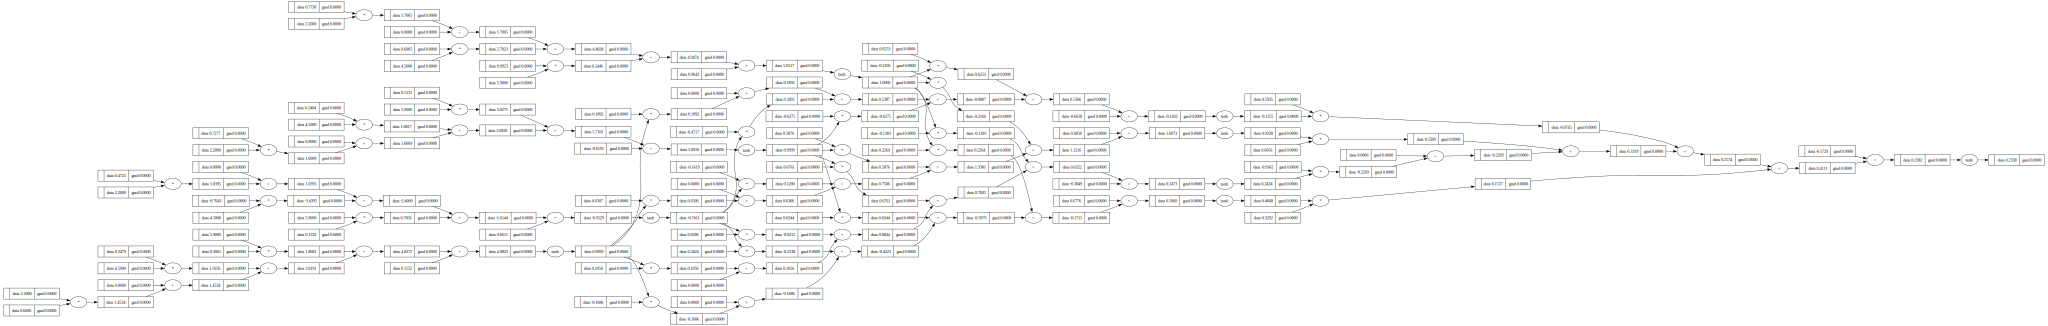

In [80]:
n(x) 
draw_dot(n(x))

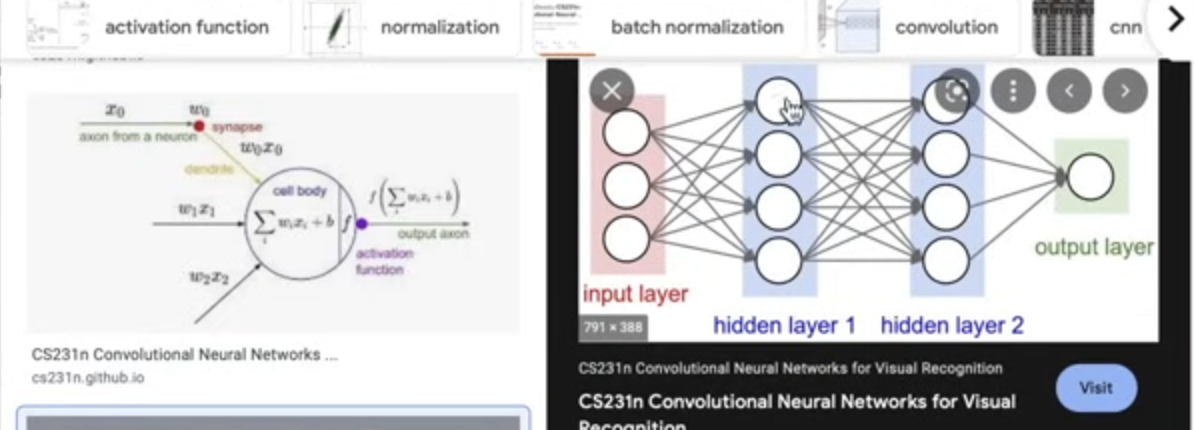

**Class Layer**: defines one vertical layer of this figure\
**class MLP**: It is just a multilayered perceptron

In [81]:
xs = [[2.0,3.0,-1.0],
      [3.0,-1.0,0.5],
      [0.5,1.0,1.0],
      [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1]
ypred = [n(x) for x in xs]
ypred

[Value(data=0.3998554541934075),
 Value(data=-0.04089586633827759),
 Value(data=0.4115620621332308),
 Value(data=0.7047961578527018)]

Currently these are the predicted values from above example
[Value(data=-0.3084228472588184),
 Value(data=-0.6514719833292771),
 Value(data=-0.5923568167728519),
 Value(data=-0.3233183759531563)]\
 We want them to be 1.0,-1.0 and so on.\
 **Tuning the neural nets to better predict weight:** A single number if calculated which is called loss

In [83]:
loss = sum((ysc - ypredc)**2 for ysc,ypredc in zip(ys,ypred))
loss.backward();

In [86]:
len(n.parameters())

41

 **NEURON**\
 Multiple inputs come and are multiplied by weights at the synopsis, so effectively inputs are xiwi
 Inside cell body, SIG(xiwi) + bias (bias helps to shift the activation function horizontally, represents the output when all the inputs are 0)
 This summation is passed through an activation function

In [317]:
x1 = Value(2.0, label='x1');
x2 = Value(0.0, label = 'x2');
w1 = Value(-3.0, label = 'w1');
w2 = Value(1.0, label = 'w2');
# bias 
b = Value(6.8813735870195432, label = 'b');
x1w1 = x1*w1; x1w1.label = 'x1w1';
x2w2 = x2*w2; x2w2.label = 'x2w2';
sigma = x1w1 + x2w2; sigma.label = 'summation';
n = sigma + b; n.label = 'n';
# e = (2*n).exp(); e.label = 'e';
# o = (e-1) / (e+1);
o = n.tanh();
o.label = 'o';
o.grad = 1.0;
o.backward(); 

In [316]:
e

Value(data=5.828427124746192)

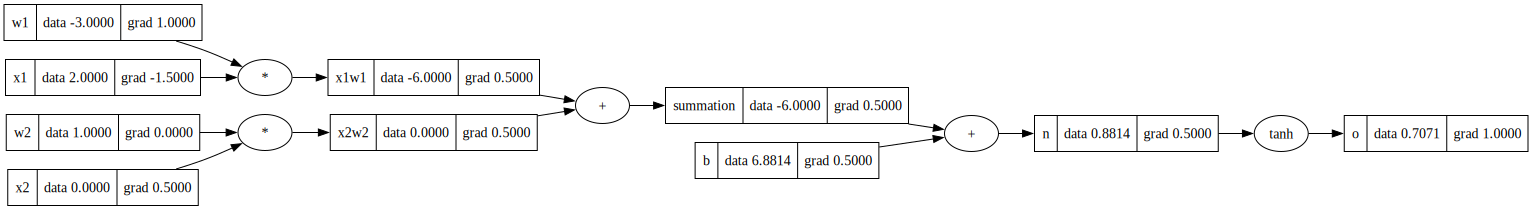

In [318]:
draw_dot(o)